In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
import scipy.integrate

from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import statsmodels.api as sm
import xlrd
import math

# Read in data

In [61]:
# COVID-19 cases
df_case = pd.read_csv("../02_Data//01_COVID/covid_us_county.csv")
df_case.dropna(inplace=True)

# Socio-Demographics
df_sd = pd.read_csv("../02_Data//02_SociaDemographics/us_final.csv",index_col=0)
df_sd = df_sd.reset_index()

# Policy
df_policy = pd.read_excel(r"../02_Data\03_Policy\COVID_StatePolicy_final.xlsx")
df_policy.head()

# Mobility
df_mobility = pd.read_csv("../02_Data//05_Mobility/2020_US_Region_Mobility_Report.csv")

## Preprocess and clean data

In [62]:
df_case

,fips,county,state,lat,long,date,cases,state_code,deaths
0,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-22,0,AL,0
1,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-23,0,AL,0
2,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-24,0,AL,0
3,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-25,0,AL,0
4,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-26,0,AL,0
...,...,...,...,...,...,...,...,...,...
945215,56045.0,Weston,Wyoming,43.839612,-104.567488,2020-10-26,132,WY,0
945216,56045.0,Weston,Wyoming,43.839612,-104.567488,2020-10-27,139,WY,0
945217,56045.0,Weston,Wyoming,43.839612,-104.567488,2020-10-28,148,WY,0
945218,56045.0,Weston,Wyoming,43.839612,-104.567488,2020-10-29,155,WY,0


In [69]:
# COVID-19 cases
mData1 = []
df_case['fips'] = df_case.fips.astype(int)
df_sir = df_case.copy()
fips = list(set(df_sir['fips']))
for fip in tqdm(fips):
    df = df_sir[(df_sir['fips']==fip)]
    
    df = df[df['cases']>=5]
    df = df.reset_index(drop=True)
    df = df.reset_index()

    df = df.to_dict("records")
    # 7 day Moving average
    for i in range(len(df)-6):
        mdf = df[i:i+7]
        mdf_case = [m['cases'] for m in mdf]
        mdf_death = [m['deaths'] for m in mdf]
        df[i+3]['cases_7'] = np.sum(mdf_case)/7
        df[i+3]['deaths_7'] = np.sum(mdf_death)/7
        df[i+3]['day_index'] = df[i+3]['index']
        mData1.append(df[i+3])

# # Add R0 Column
#     # Calcu R0_dt
# for i in range(len(df)-1):  
#     dt = 1  ### 向前推dt天范围内的R0  
#     mdf = df[i+1-dt:i+2]
#     mdf_case = [m['cases'] for m in mdf]
    
# #   r = math.log(b(t)/b(t-dt))/dt  ### R0<1, when r<0, when b(t)<b(t-dt) 
#     r = math.log(mdf_case[i+1] / mdf_case[i+1-dt]) / dt
#     df[i+1]['r'] = r
#     df[i+1]['R0'] = (1 + r * TL) * (1 + r * TI)

#     mData1.append(df[i+1])
    
# The log value
for i in range(len(mData1)-1):
    mData1[i+1]['delta_case'] = np.log(mData1[i+1]['cases_7']) - np.log(mData1[i]['cases_7'])
    pass
del mData1[0]



df_case_delta = pd.DataFrame(mData1)

100%|█████████████████████████████████████████████████████████████████████████████| 3241/3241 [00:31<00:00, 103.90it/s]


In [70]:
display(df_case_delta[:55])
display(df_case_delta)
df_case_delta[4:5]['cases']

,index,fips,county,state,lat,long,date,cases,state_code,deaths,cases_7,deaths_7,day_index,delta_case
0,4,41001,Baker,Oregon,44.709156,-117.674988,2020-07-08,8,OR,0,7.285714,0.000000,4,0.125163
1,5,41001,Baker,Oregon,44.709156,-117.674988,2020-07-09,8,OR,0,8.285714,0.000000,5,0.128617
2,6,41001,Baker,Oregon,44.709156,-117.674988,2020-07-10,9,OR,0,9.285714,0.000000,6,0.113944
3,7,41001,Baker,Oregon,44.709156,-117.674988,2020-07-11,11,OR,0,10.285714,0.000000,7,0.102279
4,8,41001,Baker,Oregon,44.709156,-117.674988,2020-07-12,12,OR,0,11.000000,0.000000,8,0.067139
5,9,41001,Baker,Oregon,44.709156,-117.674988,2020-07-13,12,OR,0,11.714286,0.000000,9,0.062914
6,10,41001,Baker,Oregon,44.709156,-117.674988,2020-07-14,12,OR,0,12.285714,0.000000,10,0.047628
7,11,41001,Baker,Oregon,44.709156,-117.674988,2020-07-15,13,OR,0,12.571429,0.000000,11,0.022990
8,12,41001,Baker,Oregon,44.709156,-117.674988,2020-07-16,13,OR,0,12.714286,0.000000,12,0.011300
9,13,41001,Baker,Oregon,44.709156,-117.674988,2020-07-17,13,OR,0,12.857143,0.000000,13,0.011173


,index,fips,county,state,lat,long,date,cases,state_code,deaths,cases_7,deaths_7,day_index,delta_case
0,4,41001,Baker,Oregon,44.709156,-117.674988,2020-07-08,8,OR,0,7.285714,0.0,4,0.125163
1,5,41001,Baker,Oregon,44.709156,-117.674988,2020-07-09,8,OR,0,8.285714,0.0,5,0.128617
2,6,41001,Baker,Oregon,44.709156,-117.674988,2020-07-10,9,OR,0,9.285714,0.0,6,0.113944
3,7,41001,Baker,Oregon,44.709156,-117.674988,2020-07-11,11,OR,0,10.285714,0.0,7,0.102279
4,8,41001,Baker,Oregon,44.709156,-117.674988,2020-07-12,12,OR,0,11.000000,0.0,8,0.067139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577041,178,39069,Henry,Ohio,41.333964,-84.068306,2020-10-23,488,OH,17,486.714286,17.0,178,0.024362
577042,179,39069,Henry,Ohio,41.333964,-84.068306,2020-10-24,498,OH,17,498.428571,17.0,179,0.023783
577043,180,39069,Henry,Ohio,41.333964,-84.068306,2020-10-25,503,OH,17,509.428571,17.0,180,0.021829
577044,181,39069,Henry,Ohio,41.333964,-84.068306,2020-10-26,531,OH,17,520.857143,17.0,181,0.022186


4    12
Name: cases, dtype: int64

In [6]:
# Mobility

df_mobility_processed = df_mobility.drop(labels=['census_fips_code','metro_area','country_region_code', 'country_region'], axis=1)

# there are 6 different place categories provided by google mobility, so let's store them in a simple list.
mobility_predictors = df_mobility_processed.columns[4:].tolist()
mobility_fontsize = 30

# check how many rows have values for all 6 predictors
df_mobility_processed_2 = df_mobility_processed.loc[df_mobility_processed[mobility_predictors[0]].notnull() & df_mobility_processed[mobility_predictors[1]].notnull() & df_mobility_processed[mobility_predictors[2]].notnull() &
       df_mobility_processed[mobility_predictors[3]].notnull() & df_mobility_processed[mobility_predictors[4]].notnull() & df_mobility_processed[mobility_predictors[5]].notnull()]
df_mobility_processed_2 = df_mobility_processed_2.loc[df_mobility_processed['sub_region_1'].isnull()]

In [7]:
# Policy

df_policy_merge=df_case.merge(df_policy, on=['state_code','state'],how='left')
df_policy_merge['date'] = pd.to_datetime(df_policy_merge['date'])

# get daily data from cumulative sum
df_policy_merge['new_cases']=df_policy_merge['cases'].groupby(df_policy_merge['fips']).diff().fillna(0)
df_policy_merge['new_deaths']=df_policy_merge['deaths'].groupby(df_policy_merge['fips']).diff().fillna(0)

# impute 0 for dates with negative case inceases
df_policy_merge['new_cases']=df_policy_merge['new_cases'].clip(lower=0)
df_policy_merge['new_deaths']=df_policy_merge['new_deaths'].clip(lower=0)

# Calculate 7-day moving average

df_policy_merge['cases_7day_ave'] = df_policy_merge.groupby('fips', as_index=False)['new_cases'].rolling(window=7,center=True).mean().fillna(0).reset_index(
    0, drop=True)

df_policy_merge['policy_home']=np.where((df_policy_merge['date'].astype('datetime64[ns]')>=df_policy_merge['stay_at_home'].astype('datetime64[ns]')) 
                                 & (df_policy_merge['date'].astype('datetime64[ns]')<=df_policy_merge['end_stay_at_home'].astype('datetime64[ns]')), 1, 0)

df_policy_merge['policy_school']=np.where((df_policy_merge['date'].astype('datetime64[ns]')>=df_policy_merge['close_school'].astype('datetime64[ns]')), 1, 0)

df_policy_merge['policy_business']=np.where((df_policy_merge['date'].astype('datetime64[ns]')>=df_policy_merge['close_nonessential_business'].astype('datetime64[ns]')) 
                                 & (df_policy_merge['date'].astype('datetime64[ns]')<=df_policy_merge['reopen_business'].astype('datetime64[ns]')), 1, 0)

df_policy_merge['policy_restaurant']=np.where((df_policy_merge['date'].astype('datetime64[ns]')>=df_policy_merge['close_restaurant'].astype('datetime64[ns]')) 
                                 & (df_policy_merge['date'].astype('datetime64[ns]')<=df_policy_merge['reopen_restaurant'].astype('datetime64[ns]')), 1, 0)

df_policy_merge['policy_facemask']=np.where((df_policy_merge['date'].astype('datetime64[ns]')>=df_policy_merge['facemask'].astype('datetime64[ns]')), 1, 0)

df_policy_merge['policy_gym']=np.where((df_policy_merge['date'].astype('datetime64[ns]')>=df_policy_merge['close_gym'].astype('datetime64[ns]')) 
                                 & (df_policy_merge['date'].astype('datetime64[ns]')<=df_policy_merge['reopen_gym'].astype('datetime64[ns]')), 1, 0)

df_policy_merge['policy_theater']=np.where((df_policy_merge['date'].astype('datetime64[ns]')>=df_policy_merge['close_theater'].astype('datetime64[ns]')) 
                                 & (df_policy_merge['date'].astype('datetime64[ns]')<=df_policy_merge['reopen_theater'].astype('datetime64[ns]')), 1, 0)

df_policy_merge['policy_bar']=np.where((df_policy_merge['date'].astype('datetime64[ns]')>=df_policy_merge['close_bar'].astype('datetime64[ns]')) 
                                 & (df_policy_merge['date'].astype('datetime64[ns]')<=df_policy_merge['reopen_bar'].astype('datetime64[ns]')), 1, 0)


In [8]:
# Socio Demographics

df_sd.loc[549,'ChildPoverty'] = df_sd[df_sd["state"]=="Hawaii"]["ChildPoverty"].median()

df_missing_crime = df_sd[df_sd["crime_rate_per_100000"].isnull()]
df_missing_crime_num = df_missing_crime.groupby("state")["state"].count()

crime_columns = ["crime_rate_per_100000","IDNO","Crime_CPOPARST","Crime_CPOPCRIM","Crime_AG_OFF","Crime_COVIND","Crime_MODINDX","Crime_MURDER","Crime_RAPE","Crime_ROBBERY","Crime_AGASSLT","Crime_BURGLRY","Crime_LARCENY","Crime_MVTHEFT","Crime_ARSON"]
state_list = ["Alaska","New Mexico","South Dakota"]
for state in state_list:
    index_list = df_missing_crime[df_missing_crime['state']==state]["index"].tolist()
    for crime in crime_columns:
        for index in index_list:
            df_sd.loc[index-1,crime] = df_sd[df_sd['state']==state][crime].median()
            pass
        pass
    pass



In [9]:
df_policy_merge

,fips,county,state,lat,long,date,cases,state_code,deaths,state_fips,...,new_deaths,cases_7day_ave,policy_home,policy_school,policy_business,policy_restaurant,policy_facemask,policy_gym,policy_theater,policy_bar
0,1001,Autauga,Alabama,32.539527,-86.644082,2020-01-22,0,AL,0,1,...,0.0,0.000000,0,0,0,0,0,0,0,0
1,1001,Autauga,Alabama,32.539527,-86.644082,2020-01-23,0,AL,0,1,...,0.0,0.000000,0,0,0,0,0,0,0,0
2,1001,Autauga,Alabama,32.539527,-86.644082,2020-01-24,0,AL,0,1,...,0.0,0.000000,0,0,0,0,0,0,0,0
3,1001,Autauga,Alabama,32.539527,-86.644082,2020-01-25,0,AL,0,1,...,0.0,0.000000,0,0,0,0,0,0,0,0
4,1001,Autauga,Alabama,32.539527,-86.644082,2020-01-26,0,AL,0,1,...,0.0,0.000000,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
917198,56045,Weston,Wyoming,43.839612,-104.567488,2020-10-26,132,WY,0,56,...,0.0,5.714286,0,1,0,0,0,0,0,0
917199,56045,Weston,Wyoming,43.839612,-104.567488,2020-10-27,139,WY,0,56,...,0.0,5.428571,0,1,0,0,0,0,0,0
917200,56045,Weston,Wyoming,43.839612,-104.567488,2020-10-28,148,WY,0,56,...,0.0,0.000000,0,1,0,0,0,0,0,0
917201,56045,Weston,Wyoming,43.839612,-104.567488,2020-10-29,155,WY,0,56,...,0.0,0.000000,0,1,0,0,0,0,0,0


# EDA Figures

## Daily new cases per county

We see a clear weekly circular patterns in the newly confirmed cases. This indicates that we might need to do a 7-day moving average to overcome the week effect.

There are 3 rapid growing period in the past eight months:
* Mid March - Begining of April
* Mid June - Mid July
* End of September - Present

We notice another point about the confidence interval. It seems that the second growing period has a bigger CI comparing to the first one and the third one, showing that the differences of covid-19 cases among counties are larger.

In [10]:
# # new cases
# plt.figure(figsize=(16,9))
# g=sns.lineplot(x="date", y="new_cases",
#              data=df_policy_merge)
# locator = mdates.AutoDateLocator()
# formatter = mdates.ConciseDateFormatter(locator,formats=["","%b", '%d', '%H:%M', '%H:%M', '%S.%f'],show_offset=False)
# g.xaxis.set_major_locator(locator)
# g.xaxis.set_major_formatter(formatter)
# g.set_xlim(df_policy_merge['date'].min(),df_policy_merge['date'].max())
# g.set_xlabel('Date')
# g.set_ylabel('Daily new cases per county')
# plt.title("Newly confirmed cases",fontsize=16)
# plt.show()

In [11]:
df_policy_merge

,fips,county,state,lat,long,date,cases,state_code,deaths,state_fips,...,new_deaths,cases_7day_ave,policy_home,policy_school,policy_business,policy_restaurant,policy_facemask,policy_gym,policy_theater,policy_bar
0,1001,Autauga,Alabama,32.539527,-86.644082,2020-01-22,0,AL,0,1,...,0.0,0.000000,0,0,0,0,0,0,0,0
1,1001,Autauga,Alabama,32.539527,-86.644082,2020-01-23,0,AL,0,1,...,0.0,0.000000,0,0,0,0,0,0,0,0
2,1001,Autauga,Alabama,32.539527,-86.644082,2020-01-24,0,AL,0,1,...,0.0,0.000000,0,0,0,0,0,0,0,0
3,1001,Autauga,Alabama,32.539527,-86.644082,2020-01-25,0,AL,0,1,...,0.0,0.000000,0,0,0,0,0,0,0,0
4,1001,Autauga,Alabama,32.539527,-86.644082,2020-01-26,0,AL,0,1,...,0.0,0.000000,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
917198,56045,Weston,Wyoming,43.839612,-104.567488,2020-10-26,132,WY,0,56,...,0.0,5.714286,0,1,0,0,0,0,0,0
917199,56045,Weston,Wyoming,43.839612,-104.567488,2020-10-27,139,WY,0,56,...,0.0,5.428571,0,1,0,0,0,0,0,0
917200,56045,Weston,Wyoming,43.839612,-104.567488,2020-10-28,148,WY,0,56,...,0.0,0.000000,0,1,0,0,0,0,0,0
917201,56045,Weston,Wyoming,43.839612,-104.567488,2020-10-29,155,WY,0,56,...,0.0,0.000000,0,1,0,0,0,0,0,0


## The Policy Implementation Progress

It can be seen that there are most policies, except "facemask mandates", are implemented around the same time period (i.e., end of March and early April) and end in May. After August, the only policies left are School closure and Facemask mandate.

The ratio here is based on the county numbers instead of the coverage of population.

In such a case, we believe that it could help to explain the cases growth when we focus on the policy releasing period 

NameError: name 'g' is not defined

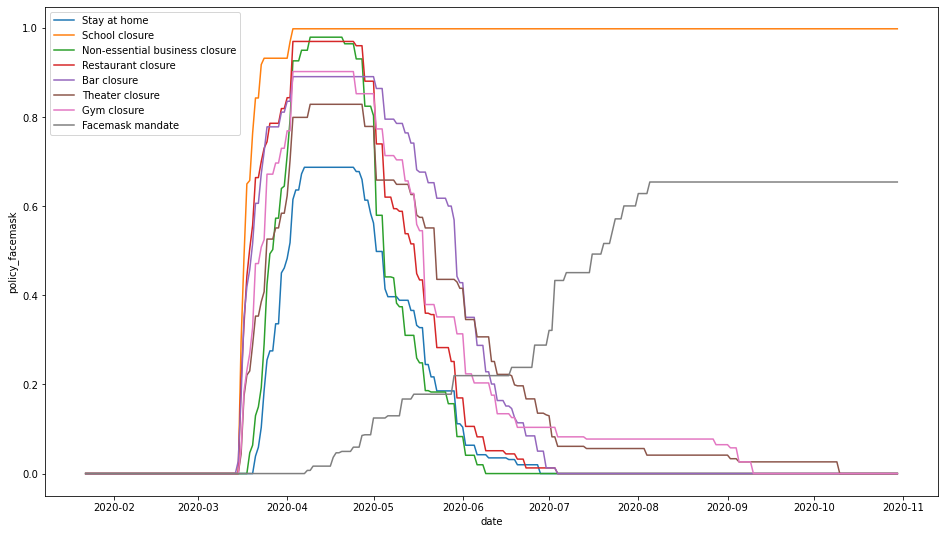

In [12]:
plt.figure(figsize=(16,9))
sns.lineplot(x="date", y="policy_home",ci=None,label="Stay at home",
             data=df_policy_merge)
sns.lineplot(x="date", y="policy_school",ci=None,label="School closure",
             data=df_policy_merge)
sns.lineplot(x="date", y="policy_business",ci=None,label="Non-essential business closure",
             data=df_policy_merge)
sns.lineplot(x="date", y="policy_restaurant",ci=None,label="Restaurant closure",
             data=df_policy_merge)
sns.lineplot(x="date", y="policy_bar",ci=None,label="Bar closure",
             data=df_policy_merge)
sns.lineplot(x="date", y="policy_theater",ci=None,label="Theater closure",
             data=df_policy_merge)
sns.lineplot(x="date", y="policy_gym",ci=None,label="Gym closure",
             data=df_policy_merge)
sns.lineplot(x="date", y="policy_facemask",ci=None,label="Facemask mandate",
             data=df_policy_merge)

# g.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
# g.xaxis.set_major_locator(mdates.DayLocator(interval=30))
g.set_xlabel('Date')
g.set_ylabel('Proportion of counties under each policy')
plt.legend(fontsize='large',bbox_to_anchor=(1.05, 1),loc='upper left')
plt.title("Policy implemented progress",fontsize=16)
plt.show()

## Correlation between Mobility Index

We see that some predictors are more correlated than others. 

Taking Transit station as an example, we could see nearly all other index except for residential have positive correlation with it. It makes sense since the more share an individual stays at home, the less likely he or she goes out

Except for the correlation pattern, we also noticed that the points are clustering in some figures. Taking retail and workplace as an example, we could see there are two distinguished clustering of points implicating a specifi type of people.

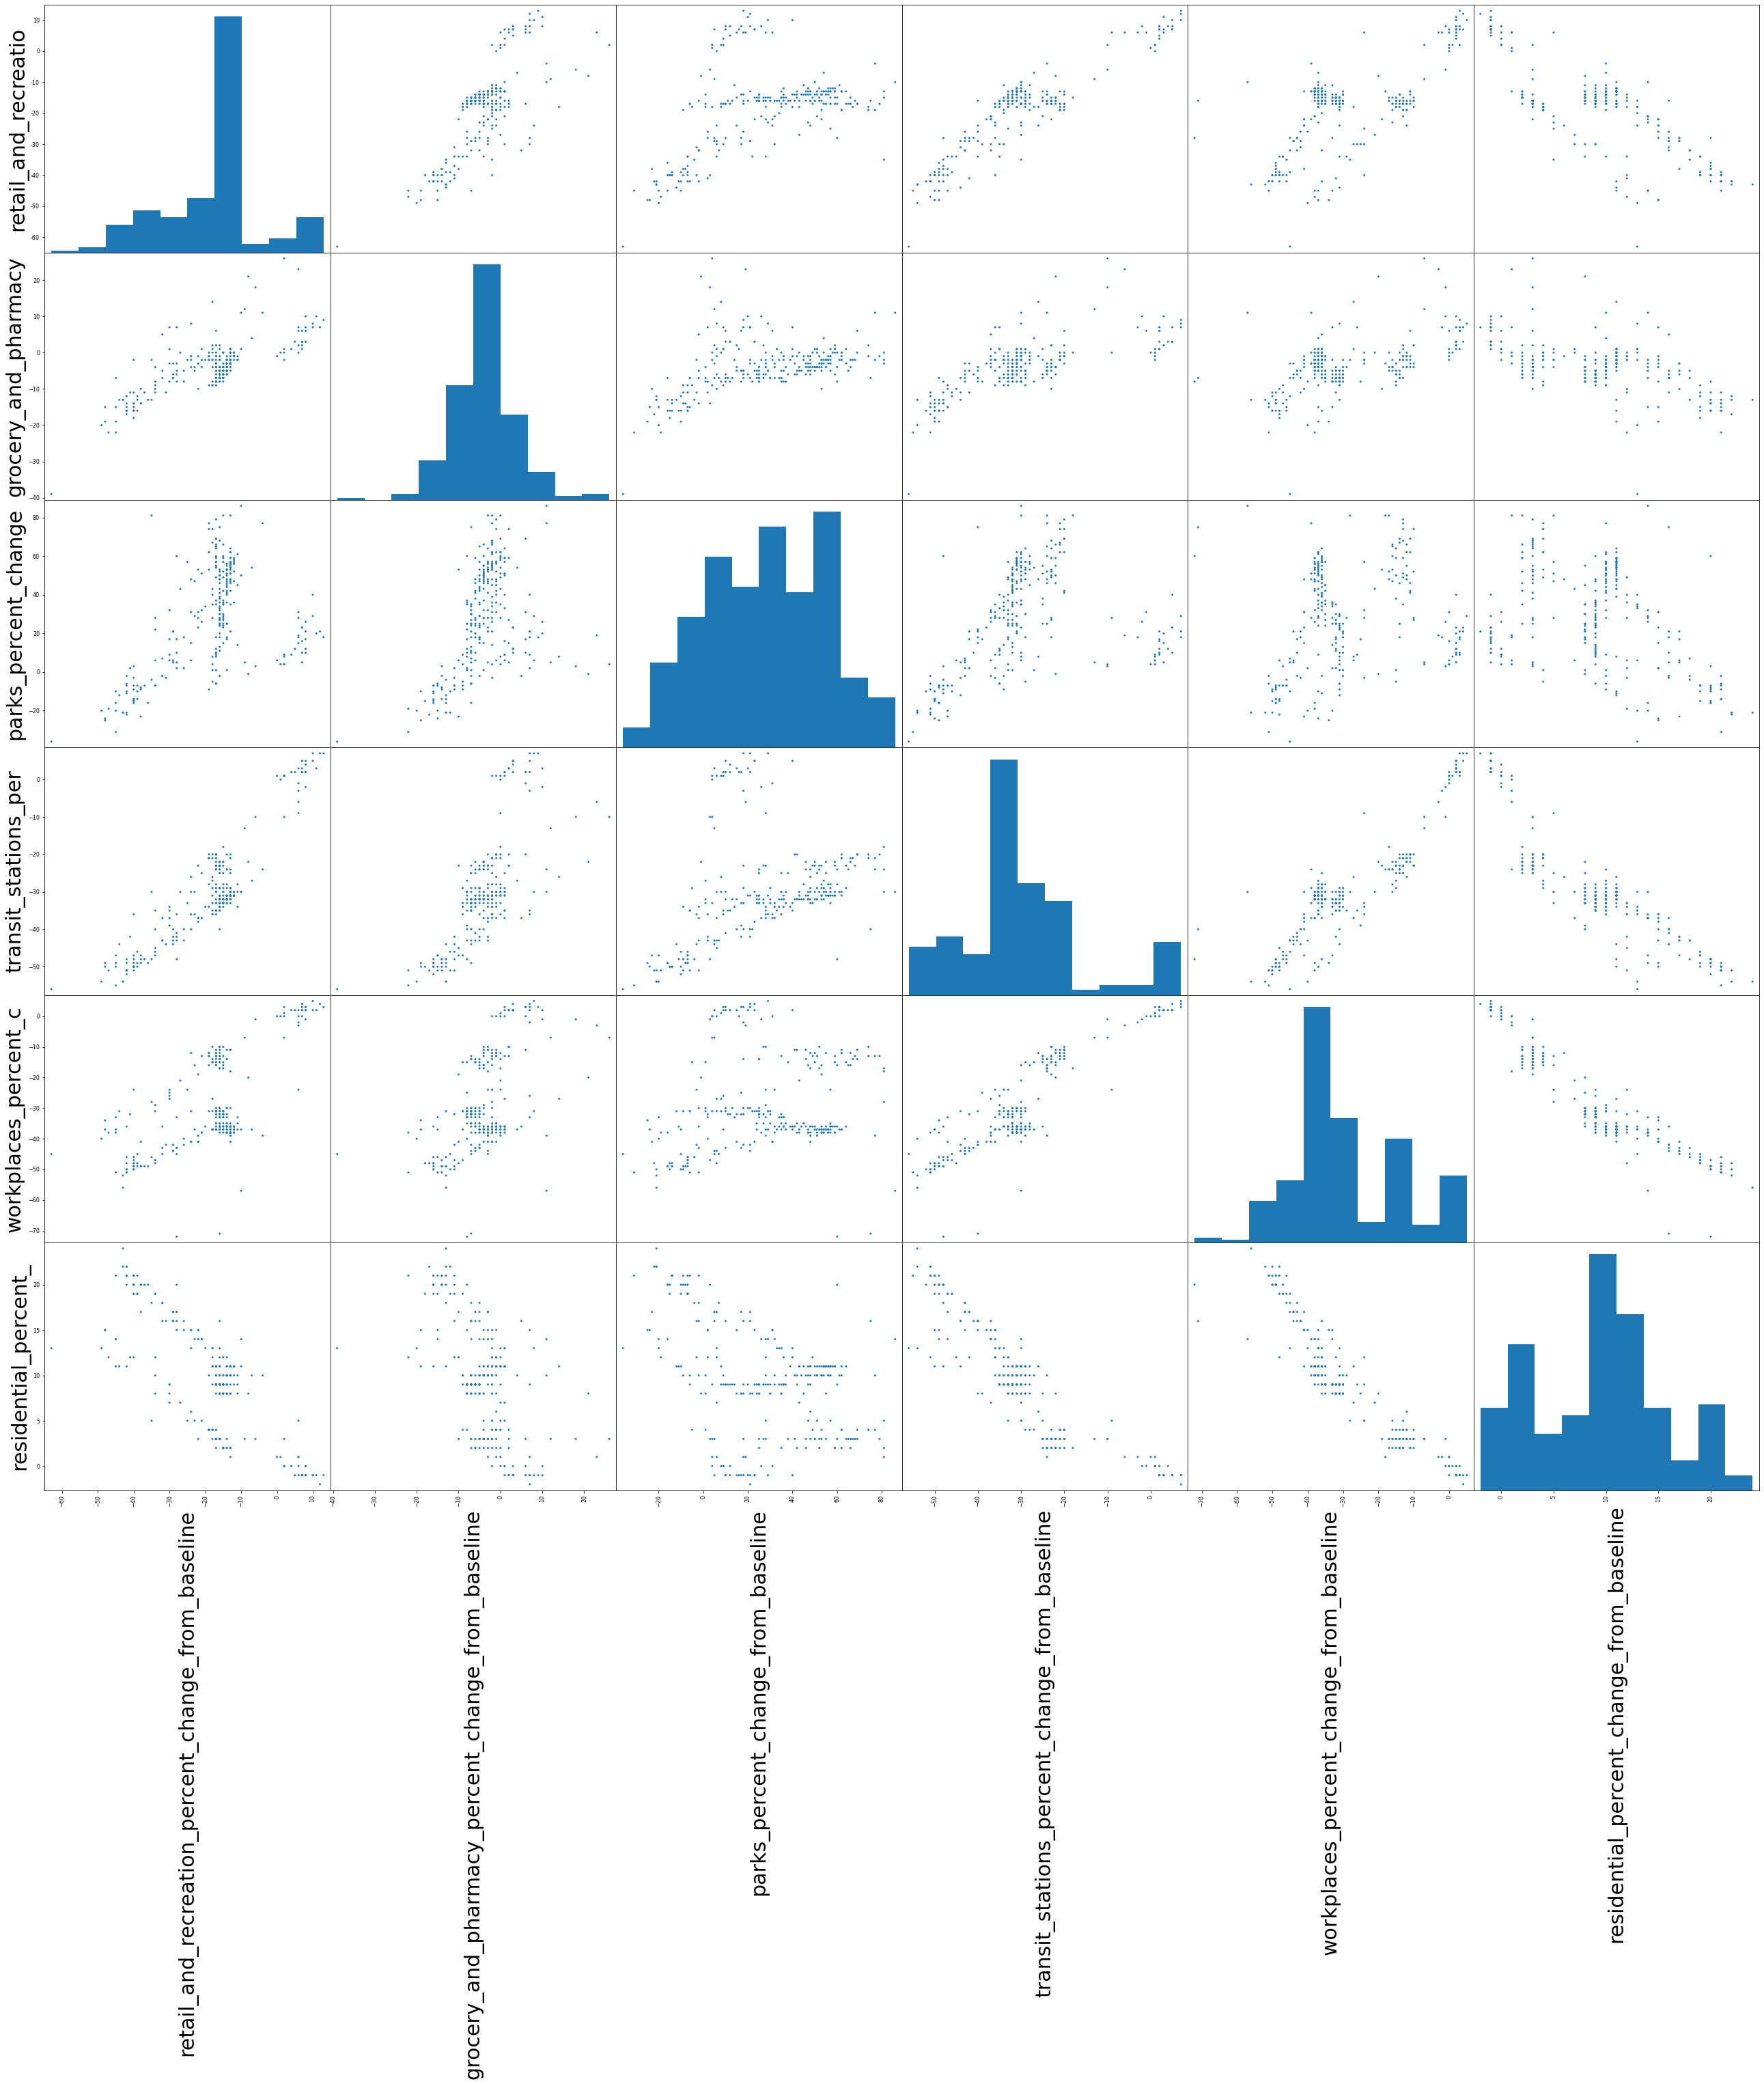

In [13]:
scatter = pd.plotting.scatter_matrix(df_mobility_processed.loc[df_mobility_processed['sub_region_1'].isnull()], alpha=1, figsize=(45, 40))
for ax in scatter.ravel():
    ax.set_xlabel(ax.get_xlabel(), rotation=90, fontsize=mobility_fontsize)
    ax.set_ylabel(ax.get_ylabel()[0:20], fontsize=mobility_fontsize)

## Mobility index comparison

COVID-19 has impact on nearly all aspects of the daily life and citizens will have different behaviour changes. Here we list 3 of them including retail, grocery and parks. All of them are showing a pattern of weekly cycle.

Due to the policy restriction and voluntary visit reduction, grocery and parks are facing dropping comparing to the baseline. However, since the family needs to be fed so the extent of change in grocery is smaller than recreation.

Park experienced a totally different trend. People are more likely to visit the parks. We assume the reason could be the close of exercise room so people switch to doing exercise at parks.

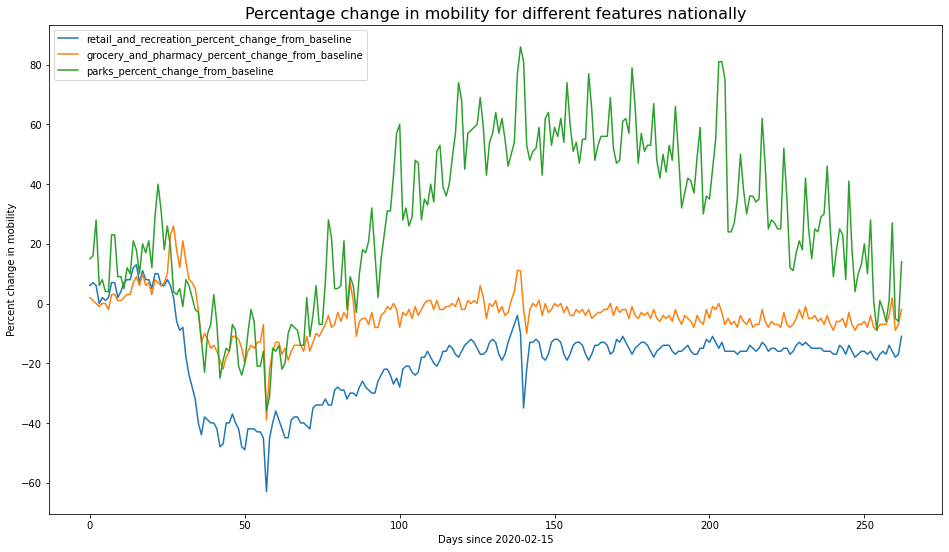

In [14]:
plt.figure(figsize=(16,9))
for predictor in mobility_predictors[0:3]:
    plt.plot(df_mobility_processed_2[predictor], label=f"{predictor}")
    plt.title("Percentage change in mobility for different features nationally",fontsize=16)
    plt.xlabel(f"Days since {df_mobility_processed_2['date'][0]}")
    plt.ylabel("Percent change in mobility")
    
plt.legend()

## Mobility index comparison

We show another three index in the google mobility including transit station, workplace and residential.

Transit and workplace are very similar. First we understand it as the number of workers who travel to office via transit were dropping during the COVID-19 period. Second, it might implicate the majority of people who take transit are more likely to go to the work place since they share a similar drop.

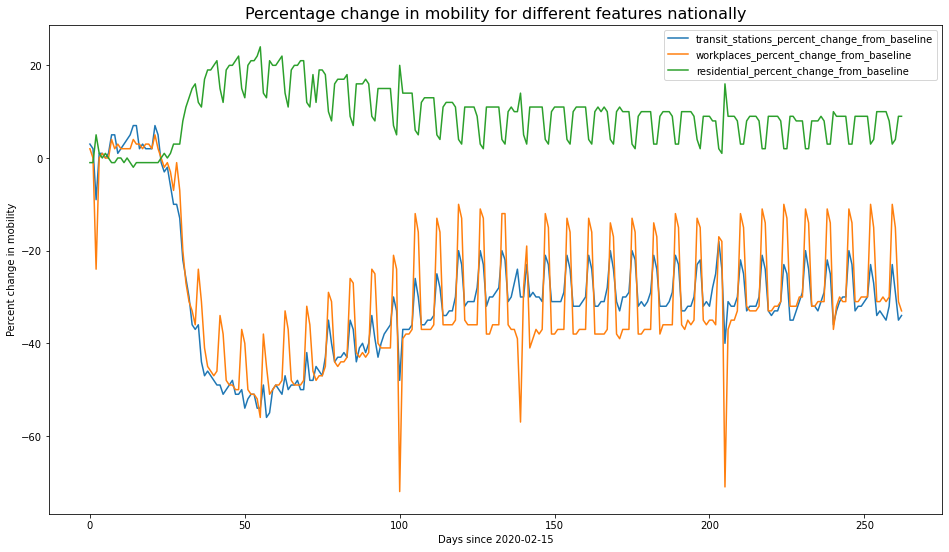

In [15]:
plt.figure(figsize=(16,9))
for predictor in mobility_predictors[3:]:
    plt.plot(df_mobility_processed_2[predictor], label=f"{predictor}")
    plt.title("Percentage change in mobility for different features nationally",fontsize=16)
    plt.xlabel(f"Days since {df_mobility_processed_2['date'][0]}")
    plt.ylabel("Percent change in mobility")
    
plt.legend()

## Correlations among county socio-demographics

To understand better about our county data, the correlation map is presented.

1, The higher the median age, the higher ratio of white people in a county, the less hispanic people in a county

2, The higher the median age, the higher ratio of self-employed

3, The larger the population size, the higher ratio of Asian in a county.

4, The larger the population size, the higher income and percap income;

5, The larger the population size, the higher professional workers; the less construction workers;

6, The larger the population size, the higher ratio of people taking public transit.

7, While the longitude increase, the female percentage is larger.

8, The larger female percentage, the more are choosing to drive; the liss are choosing to walk

9, While the latitude increase, the lower ratio of hispanic people and the higher ratio of white people.

10, While the latitude increase, the higher income; the less unemployment

There are many other interest correlations among the figure

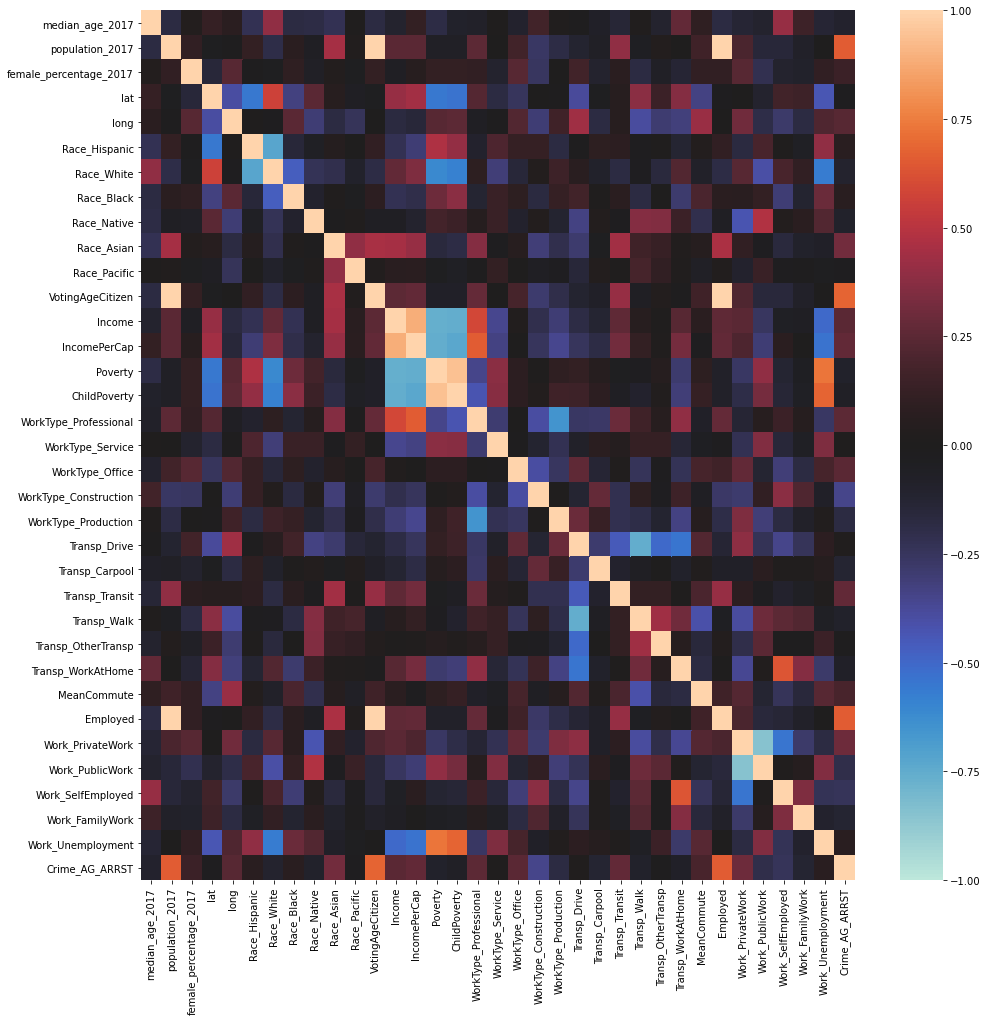

In [16]:
cor = df_sd.drop(columns=["index","fips","IncomeErr","IncomePerCapErr"]+crime_columns).corr()
plt.figure(figsize=(16,16))
sns.heatmap(cor,vmin=-1,vmax=1,center=0)

In [17]:
df_case_delta = df_case_delta[(df_case_delta['cases_7']>=10)&(df_case_delta['date']>="2020-03-01")&(df_case_delta['date']<"2020-10-01")&(df_case_delta['delta_case']>0)]
df_case_delta.dropna(inplace=True)

# Putting all observations in regression
df_case_demo = pd.merge(df_case_delta[['fips','delta_case','date','day_index']],df_sd.drop(columns=["index","Race_White","WorkType_Office","Transp_Drive","Work_PrivateWork","IncomeErr","IncomePerCapErr","county","state","state_code","Crime_AG_ARRST"]+crime_columns),left_on="fips",right_on="fips")


# Averaging the growth rate
X = df_case_demo.drop(columns=["delta_case"])
y = df_case_demo['delta_case']

X['median_age_2017'] = X['median_age_2017']/100
X['l_population_2017'] = np.log(X['population_2017'])
X['female_percentage_2017'] = X['female_percentage_2017'] / 100
X['Race_Hispanic'] = X['Race_Hispanic'] / 100
X['Race_Black'] = X['Race_Black'] / 100
X['Race_Native'] = X['Race_Native'] / 100
X['Race_Asian'] = X['Race_Asian'] / 100
X['Race_Pacific'] = X['Race_Pacific'] / 100
X['l_income'] = np.log(X['Income'])
X['WorkType_Professional'] = X['WorkType_Professional'] / 100
X['WorkType_Construction'] = X['WorkType_Construction'] / 100
X['WorkType_Service'] = X['WorkType_Service'] / 100
X['WorkType_Production'] = X['WorkType_Production'] / 100

columns = list(X.columns)
del columns[columns.index('fips')]
del columns[columns.index('date')]
for index1,f1 in enumerate(columns):
    for index2, f2 in enumerate(columns[index1:]):
        X[f1 + "_" + f2] = X[f1] * X[f2]       
        pass
    pass


In [18]:
display(df_case_demo[:55])
display(df_case_delta)

,fips,delta_case,date,day_index,median_age_2017,population_2017,female_percentage_2017,lat,long,Race_Hispanic,...,Transp_Transit,Transp_Walk,Transp_OtherTransp,Transp_WorkAtHome,MeanCommute,Employed,Work_PublicWork,Work_SelfEmployed,Work_FamilyWork,Work_Unemployment
0,41001,0.102279,2020-07-11,7,48.2,15984,48.498498,44.709153,-117.675304,3.9,...,0.0,5.3,2.9,7.4,16.0,6354,18.6,10.4,0.3,7.3
1,41001,0.067139,2020-07-12,8,48.2,15984,48.498498,44.709153,-117.675304,3.9,...,0.0,5.3,2.9,7.4,16.0,6354,18.6,10.4,0.3,7.3
2,41001,0.062914,2020-07-13,9,48.2,15984,48.498498,44.709153,-117.675304,3.9,...,0.0,5.3,2.9,7.4,16.0,6354,18.6,10.4,0.3,7.3
3,41001,0.047628,2020-07-14,10,48.2,15984,48.498498,44.709153,-117.675304,3.9,...,0.0,5.3,2.9,7.4,16.0,6354,18.6,10.4,0.3,7.3
4,41001,0.022990,2020-07-15,11,48.2,15984,48.498498,44.709153,-117.675304,3.9,...,0.0,5.3,2.9,7.4,16.0,6354,18.6,10.4,0.3,7.3
5,41001,0.011300,2020-07-16,12,48.2,15984,48.498498,44.709153,-117.675304,3.9,...,0.0,5.3,2.9,7.4,16.0,6354,18.6,10.4,0.3,7.3
6,41001,0.011173,2020-07-17,13,48.2,15984,48.498498,44.709153,-117.675304,3.9,...,0.0,5.3,2.9,7.4,16.0,6354,18.6,10.4,0.3,7.3
7,41001,0.032790,2020-07-18,14,48.2,15984,48.498498,44.709153,-117.675304,3.9,...,0.0,5.3,2.9,7.4,16.0,6354,18.6,10.4,0.3,7.3
8,41001,0.031749,2020-07-19,15,48.2,15984,48.498498,44.709153,-117.675304,3.9,...,0.0,5.3,2.9,7.4,16.0,6354,18.6,10.4,0.3,7.3
9,41001,0.030772,2020-07-20,16,48.2,15984,48.498498,44.709153,-117.675304,3.9,...,0.0,5.3,2.9,7.4,16.0,6354,18.6,10.4,0.3,7.3


,index,fips,county,state,lat,long,date,cases,state_code,deaths,cases_7,deaths_7,day_index,delta_case
3,7,41001,Baker,Oregon,44.709156,-117.674988,2020-07-11,11,OR,0,10.285714,0.000000,7,0.102279
4,8,41001,Baker,Oregon,44.709156,-117.674988,2020-07-12,12,OR,0,11.000000,0.000000,8,0.067139
5,9,41001,Baker,Oregon,44.709156,-117.674988,2020-07-13,12,OR,0,11.714286,0.000000,9,0.062914
6,10,41001,Baker,Oregon,44.709156,-117.674988,2020-07-14,12,OR,0,12.285714,0.000000,10,0.047628
7,11,41001,Baker,Oregon,44.709156,-117.674988,2020-07-15,13,OR,0,12.571429,0.000000,11,0.022990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577014,151,39069,Henry,Ohio,41.333964,-84.068306,2020-09-26,314,OH,14,318.285714,13.714286,151,0.016746
577015,152,39069,Henry,Ohio,41.333964,-84.068306,2020-09-27,318,OH,14,323.285714,14.000000,152,0.015587
577016,153,39069,Henry,Ohio,41.333964,-84.068306,2020-09-28,334,OH,14,329.000000,14.571429,153,0.017521
577017,154,39069,Henry,Ohio,41.333964,-84.068306,2020-09-29,337,OH,15,334.857143,15.142857,154,0.017646


In [19]:
X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=5)
X_train,X_valid,y_train,y_valid = train_test_split(X_train,y_train,test_size=0.375,random_state = 10)

X_train_info = X_train[['fips','date']]
X_test_info = X_test[['fips','date']]
X_valid_info = X_valid[['fips','date']]
X_train = X_train.drop(columns=['fips','date'])
X_test = X_test.drop(columns=['fips','date'])
X_valid = X_valid.drop(columns=['fips','date'])

In [20]:
# depth = [10,20,30,40,50]
# train_mse_322 = []
# valid_mse_322 = []
# train_r2_322 = []
# valid_r2_322 = []
# for d in tqdm(depth):
    
#     model_lr = DecisionTreeRegressor(max_depth=d)
#     model_lr.fit(X_train,y_train)

#     train_pred = model_lr.predict(X_train)
#     valid_pred = model_lr.predict(X_valid)

#     mse_score_lr_train = mean_squared_error(model_lr.predict(X_train), y_train)
#     mse_score_lr_valid = mean_squared_error(model_lr.predict(X_valid), y_valid)
#     r2_score_lr_train = r2_score(train_pred,y_train)
#     r2_score_lr_valid = r2_score(valid_pred,y_valid)
#     train_mse_322.append(mse_score_lr_train)
#     valid_mse_322.append(mse_score_lr_valid)
    
#     train_r2_322.append(r2_score_lr_train)
#     valid_r2_322.append(r2_score_lr_valid)

## Decision Tree R2 score

For X variables, we have features for each county and add a time variable simply counting the days since the county has confirmed cases more than 5 cases. For Y variable, we use delta log(new_case) to approximate the beta parameter in SIR model. We run the regression trying to predict the beta with different county features.

Currently the trainset could achieve 100% accuracy while testset achieve 69%. With implementing more advanced method, we hope to achieve a better result.

In [21]:
# best_depth_index = np.argmax(valid_r2_322)
# plt.figure(figsize=(16,9))
# plt.plot(depth,train_r2_322,"b",label="train R2")
# plt.plot(depth,valid_r2_322,"r",label="valid R2")
# plt.vlines(depth[best_depth_index],0.5, 1, linestyles ="dotted", colors ="g",label=f"best depth = {depth[best_depth_index]}")
# plt.xlabel("Depth", fontsize=16)
# plt.ylabel("Accuracy", fontsize=16)
# plt.legend()
# plt.title("Decision Tree R2 score acorss depth",fontsize=20)

# print(f"The best train score is {train_r2_322[best_depth_index]}")
# print(f"The best valid score is {valid_r2_322[best_depth_index]}")

# Calculate R0

### Formula

$$
R_{0}=\left(1+r \bar{T}_{L}\right)\left(1+r \bar{T}_{I}\right)
$$

$$
b(t)=b(t-\Delta t) e^{r \Delta t}
$$

$$
\bar{T}_{I}= \bar{S}{I} - \bar{T}_{L}
$$


$
\bar{T}_{L}\ \ is\ mean\ latent\ period.
$ 

$
\bar{T}_{I}\ \ is\ mean\ infectious\ period.
$

$
\bar{S}{I}\ \ is\ serial \ interval
$

$
r\ \ is\ reproductive \ rate.
$


Reference: \
Wallinga, J., & Lipsitch, M. (2007). How generation intervals shape the relationship between growth rates and reproductive numbers. Proceedings of the Royal Society B: Biological Sciences, 274(1609), 599-604.\
https://zhuanlan.zhihu.com/p/106983592

### Parameters Explanation

The latent period is the time from acquiring infection to the onset of infectiousness. The duration of the latent period is characteristic of particular infections.

The infectious period is the time during which someone with an infection can transmit the infection to someone else. The degree of infectiousness varies through the infectious period. 

If the latent period is shorter than the incubation period, then individuals are infectious before they have symptoms. This can help the infection to spread more easily.
If the latent period is longer than the incubation period, then people are infectious only after symptoms start. This means they can be recognised as being ill before they are infectious.


### Parameters values

Set $\bar{T}_{L}$ to 2.0, based on https://en.wikipedia.org/wiki/Latent_period_(epidemiology)#cite_note-pmid32296168-4

Set $\bar{S}{I}$ to 5.8, based on He, X., Lau, E.H.Y., Wu, P. et al. Temporal dynamics in viral shedding and transmissibility of COVID-19. Nat Med 26, 672–675 (2020). https://doi.org/10.1038/s41591-020-0869-5


In [186]:
df_case_delta = df_case_delta[(df_case_delta['cases_7']>=10)&(df_case_delta['date']>="2020-03-01")&(df_case_delta['date']<"2020-10-01")&(df_case_delta['delta_case']>0)]
df_case_delta.dropna(inplace=True)
df_case_delta

,index,fips,county,state,lat,long,date,cases,state_code,deaths,cases_7,deaths_7,day_index,delta_case
3,7,41001,Baker,Oregon,44.709156,-117.674988,2020-07-11,11,OR,0,10.285714,0.000000,7,0.102279
4,8,41001,Baker,Oregon,44.709156,-117.674988,2020-07-12,12,OR,0,11.000000,0.000000,8,0.067139
5,9,41001,Baker,Oregon,44.709156,-117.674988,2020-07-13,12,OR,0,11.714286,0.000000,9,0.062914
6,10,41001,Baker,Oregon,44.709156,-117.674988,2020-07-14,12,OR,0,12.285714,0.000000,10,0.047628
7,11,41001,Baker,Oregon,44.709156,-117.674988,2020-07-15,13,OR,0,12.571429,0.000000,11,0.022990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577014,151,39069,Henry,Ohio,41.333964,-84.068306,2020-09-26,314,OH,14,318.285714,13.714286,151,0.016746
577015,152,39069,Henry,Ohio,41.333964,-84.068306,2020-09-27,318,OH,14,323.285714,14.000000,152,0.015587
577016,153,39069,Henry,Ohio,41.333964,-84.068306,2020-09-28,334,OH,14,329.000000,14.571429,153,0.017521
577017,154,39069,Henry,Ohio,41.333964,-84.068306,2020-09-29,337,OH,15,334.857143,15.142857,154,0.017646


In [473]:
# b(t)/b(t-dt) = e^r*dt
# log(b(t)/b(t-dt)) / dt = r

# r = math.log(b(t)/b(t-dt)) / dt


In [187]:
SI = 5.7
TL = 2
TI = SI - TL
gamma = 0.1

# Add R0 Column
mData1 = []
df_case_delta['fips'] = df_case_delta.fips.astype(int)
df_sir = df_case_delta.copy()
fips = list(set(df_sir['fips']))
for fip in tqdm(fips):
    df = df_sir[(df_sir['fips']==fip)]    
    df = df[df['cases']>=5]
    df = df.to_dict("records")
    
    # Calcu R0_dt
    for i in range(len(df)-1):
        
        mdf = df[i+1-dt:i+2]
        mdf_case = [m['cases'] for m in mdf]

#       r = math.log(b(t)/b(t-dt))/dt  ### R0<1, when r<0, when b(t)<b(t-dt) 
        dt = 30  ### 向前推dt天范围内的R0  
        r = math.log(mdf_case[i+1] / mdf_case[i+1-dt]) / dt
        
        df[i+1]['R0_30'] = (1 + r * TL) * (1 + r * TI)
        
        df[i+1]['day_index'] = df[i+1]['index']
        mData1.append(df[i+1])
        
        
    # Calcu R0 
    for i in range(len(df)-1):
        mdf = df[i:i+2]
        mdf_case = [m['cases'] for m in mdf]
        mdf_case_7 = [m['cases_7'] for m in mdf]
        
        df[i+1]['R0'] = (1 + math.log(mdf_case[1]/mdf_case[0]) * TL) * (1 + math.log(mdf_case[1]/mdf_case[0]) * TI)
        df[i+1]['R0_7'] = (1 + math.log(mdf_case_7[1]/mdf_case_7[0]) * TL) * (1 + math.log(mdf_case_7[1]/mdf_case_7[0]) * TI)
        
        df[i+1]['day_index'] = df[i+1]['index']
        mData1.append(df[i+1])

df_case_R0 = pd.DataFrame(mData1)

  0%|                                                                                         | 0/3084 [00:00<?, ?it/s]


IndexError: list index out of range

In [ ]:
df_case_R0[:50]

In [188]:
df_case_R0.describe()

,index,fips,lat,long,cases,deaths,cases_7,deaths_7,day_index,delta_case,R0_A,R0,R0_7
count,858050.000000,858050.000000,858050.000000,858050.000000,858050.000000,858050.000000,858050.000000,858050.000000,858050.000000,858050.000000,858050.000000,858050.000000,858050.000000
mean,93.779122,30157.317243,37.669425,-89.959713,1391.863793,52.050466,1392.050743,52.054174,93.779122,0.026252,1.296425,1.184105,1.163174
std,49.741387,15909.584847,5.860048,14.184238,6351.904665,296.404009,6350.823695,296.308147,49.741387,0.033957,0.351191,0.751903,0.301860
min,4.000000,1001.000000,0.000000,-174.159600,5.000000,0.000000,10.000000,0.000000,4.000000,0.000038,-0.097578,-0.097635,-0.097635
25%,52.000000,18057.000000,34.070565,-95.793568,55.000000,1.000000,55.285714,1.000000,52.000000,0.007827,1.158878,1.000000,1.044895
50%,93.000000,29021.000000,37.892021,-88.265644,184.000000,4.000000,184.142857,3.714286,93.000000,0.015873,1.208805,1.060455,1.092279
75%,134.000000,45013.000000,41.336498,-82.416091,664.000000,18.000000,664.714286,17.571429,134.000000,0.031297,1.303960,1.179941,1.185479
max,214.000000,90053.000000,69.314792,0.000000,270299.000000,7330.000000,270500.142857,7330.857143,214.000000,1.456647,27.109311,141.245853,74.350775


In [189]:
df_case_De_R0 = pd.merge(df_case_R0,df_sd.drop(columns=["index","Race_White","WorkType_Office","Transp_Drive","Work_PrivateWork","IncomeErr","IncomePerCapErr","county","state","state_code","Crime_AG_ARRST"]+crime_columns),left_on="fips",right_on="fips")

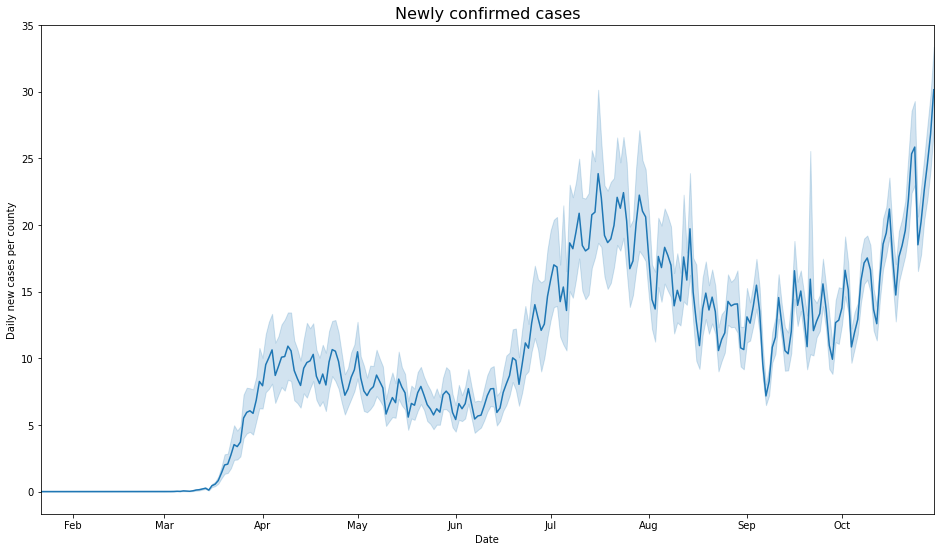

In [190]:
# new cases
plt.figure(figsize=(16,9))
g=sns.lineplot(x="date", y="new_cases",
             data=df_policy_merge)
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator,formats=["","%b", '%d', '%H:%M', '%H:%M', '%S.%f'],show_offset=False)
g.xaxis.set_major_locator(locator)
g.xaxis.set_major_formatter(formatter)
g.set_xlim(df_policy_merge['date'].min(),df_policy_merge['date'].max())
g.set_xlabel('Date')
g.set_ylabel('Daily new cases per county')
plt.title("Newly confirmed cases",fontsize=16)
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.32it/s]


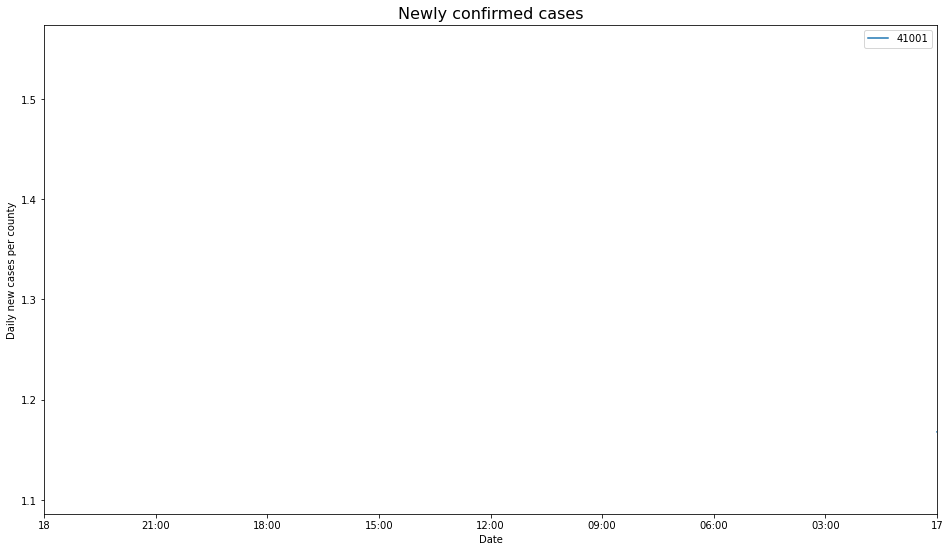

In [52]:
df_case_R0['fips'] = df_case_R0.fips.astype(int)
df_sir1 = df_case_R0.copy()
fips = list(set(df_sir1['fips']))
    
plt.figure(figsize=(16,9))

for fip in tqdm(fips[:1]):
    
    df1 = df_case_R0[(df_case_R0['fips'] == fip )]
    g=sns.lineplot(x="date", y="R0_A",ci=None, data=df1,label = fip)
    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator,formats=["","%b", '%d', '%H:%M', '%H:%M', '%S.%f'],show_offset=False)
    g.xaxis.set_major_locator(locator)
    g.xaxis.set_major_formatter(formatter)
    g.set_xlim(df_case_R0['date'].min(),df_case_R0['date'].max())
    g.set_xlabel('Date')
    g.set_ylabel('Daily new cases per county')
    plt.title("Newly confirmed cases",fontsize=16)

plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:03<00:00, 16.06it/s]


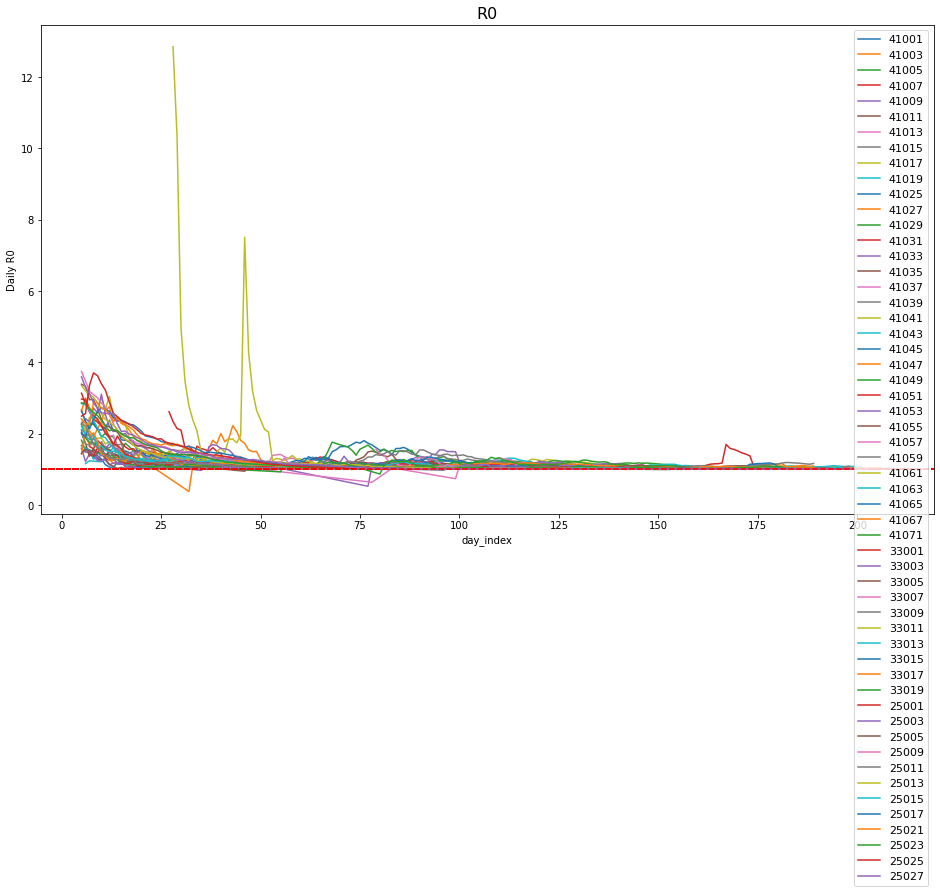

In [55]:
df_case_R0['fips'] = df_case_R0.fips.astype(int)
df_sir1 = df_case_R0.copy()
fips = list(set(df_sir1['fips']))
    
plt.figure(figsize=(16,9))

for fip in tqdm(fips[:55]):
    
    df1 = df_case_R0[(df_case_R0['fips'] == fip )]
    
    g=sns.lineplot(x="day_index", y="R0_7",ci=None, data=df1,label = fip)
    g.set_xlabel('day_index')
    g.set_ylabel('Daily R0')
    g.axhline(y=1, color='r', linestyle='--')

    plt.legend(loc='upper right',fontsize=11) 
    plt.title("R0",fontsize=16)
    
plt.show()

# SIR Model 

SIR model is a classical theory model for the prediction of pandemic. It splits the population into three compartments including Susceptible, Infectious and Recovered. The theory allows us to describe the number of people in each compartment with the ordinary differential equation thus easy to get the step-wise simulation. 

$$\frac{d S}{d t}=-\beta I S$$
$$\frac{d I}{d t}=\beta I S-\gamma I$$
$$\frac{d R}{d t}=\gamma I$$

There are 2 determinant parameters in the model. β represents the number of people that an infected person could affect. γ represents the chance for an infected person to get recovered. Another important idea which is usually mentioned is R0, the basic reproduction number. This is an epidemiologic metric used to describe the contagiousness of a pandemic which could be calculated by:

$$R_{0}=\frac \beta \gamma$$

Set $\gamma$ to 0.1, according to https://arxiv.org/abs/2003.13901v1 and https://www.who.int/bulletin/online_first/20-255695.pdf 

In [488]:
import scipy.integrate
import datetime
# model

def days_count(begin_date, end_date):
    """Count how many days there between begin_date and end_date.
    Input format: Str. eg: '2020-05-10'
    Return: Int
    """
    begin_date = datetime.datetime.strptime(begin_date, '%Y-%m-%d')
    end_date = datetime.datetime.strptime(end_date, '%Y-%m-%d')
    delta_days = end_date - begin_date
    return delta_days.days


def SIR_model(y, t, beta, gamma):
    """
    Play with scipy.odeint 微分方程函数

    """    
    S, I, R = y
    dS_dt = -beta * S * I
    dI_dt = beta * S * I - gamma * I
    dR_dt = gamma * I
    return ([dS_dt, dI_dt, dR_dt])

def SIR_Phase_Model():
    """Calcute SIR in phases with changing parameter
    Return: ndarray(n,3). [[S_ratio, I_ratio, R_ratio],...]
            ndarray(n,3). [[S_num, I_num, R_num],...]
    """
    for i in range(len(date_list)-1):
        # parameters
        gamma = gamma_list[i]
        beta = beta_list[i]
        S0 = S0_list[i]
        I0 = I0_list[i]
        R0 = R0_list[i]

        # time vector
        days = days_count(date_list[i], date_list[i+1])
        days_sequence.append(days_count(date_list[0], date_list[i+1]))
        t = np.linspace(0, days, days+1)

        # result in ratio with function: SIR_model
        res_dict[i] = scipy.integrate.odeint(SIR_model, [S0, I0, R0], t, args=(beta, gamma))
        # result in population with function: SIR_model
        res_dict_num[i] = scipy.integrate.odeint(SIR_model, [S0, I0, R0], t, args=(beta, gamma))*df_temp['population_2017'].values[0]

        # update initial S I R population number for next phase 
        S0_list.append(res_dict[i][-1][0])
        I0_list.append(res_dict[i][-1][1])
        R0_list.append(res_dict[i][-1][2])
        
        
        # append result of this phase
        if i >0:
            res_dict[i] = np.append(res_dict[i-1],res_dict[i][1:], axis=0) 
            res_dict_num[i] = np.append(res_dict_num[i-1],res_dict_num[i][1:], axis=0) 
#         print(res_dict[i].shape)

    return res_dict[len(date_list)-2], res_dict_num[len(date_list)-2]

In [505]:
# SIR Predict
res_dict = {}
res_dict_num = {}
result_dict = {}
result_dict_num = {}
predcase_dict = {}
days_sequence =[]

####################
# INPUT PARAMETERS #
####################
date_list = ['2020-05-10', '2020-07-10', '2020-8-1','2020-9-1', '2021-5-10']
beta_list = [df_temp['delta_case'].values[0]*20, 0.19 , 0.35, 0.15  ]
gamma_list = [0.1, 0.2, 0.1, 0.1]

for fip in tqdm(fips[1:5]):     #counties to be calcu
    # Set County to calcu
    df1 = df_case_De_R0[(df_case_De_R0['fips'] == fip )]
    
    # Set parameters of initial day 
    df_temp = df1[(df1['date'] == date_list[0] )]
    S0_list = [1 - df_temp['cases_7'].values[0]/(df_temp['population_2017'].values[0])]
    I0_list = [df_temp['cases_7'].values[0]/(df_temp['population_2017'].values[0])]
    R0_list = [0]
    
    # Predict use function: SIR_Phase_Model() 
    result_dict[fip], result_dict_num[fip] = SIR_Phase_Model()

# X_axis Time use to plot
days = days_count(date_list[0], date_list[-1])
T = np.linspace(0, days, days+1)

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 102.79it/s]


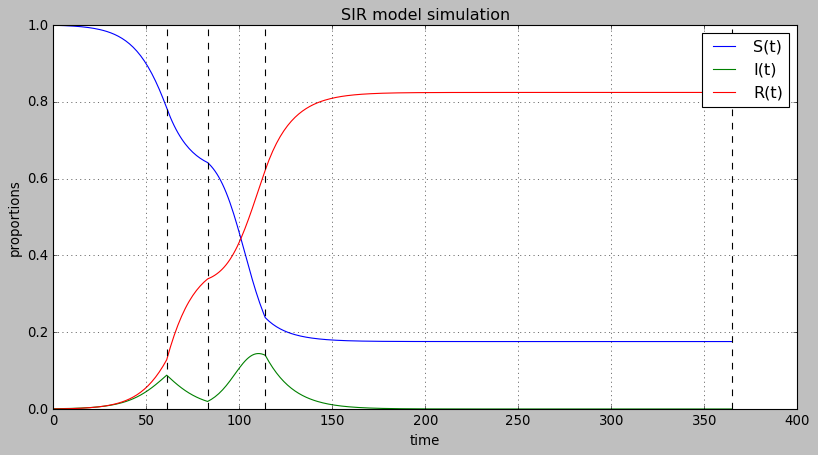

In [506]:
#plot
plt.style.use('classic')

plt.figure(figsize=[12, 6])
plt.plot(T, result_dict[41005][:, 0], label='S(t)')
plt.plot(T, result_dict[41005][:, 1], label='I(t)')
plt.plot(T, result_dict[41005][:, 2], label='R(t)')
for i in range(len(date_list)-1):
    plt.axvline(x=days_sequence[i], color='black', linestyle='--')
plt.legend()
plt.grid()
plt.xlabel('time')
plt.ylabel('proportions')
plt.title('SIR model simulation')
plt.show()

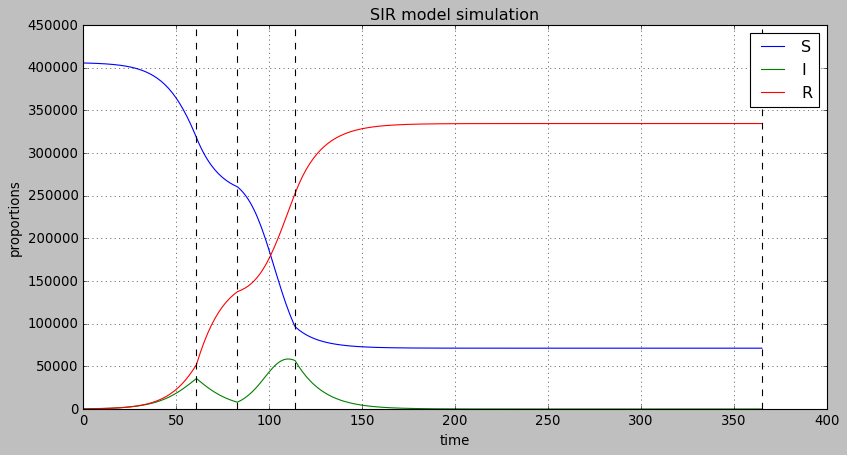

In [507]:
#plot
plt.style.use('classic')

plt.figure(figsize=[12, 6])
plt.plot(T, result_dict_num[41005][:, 0], label='S')
plt.plot(T, result_dict_num[41005][:, 1], label='I')
plt.plot(T, result_dict_num[41005][:, 2], label='R')
for i in range(len(date_list)-1):
    plt.axvline(x=days_sequence[i], color='black', linestyle='--')
plt.legend()
plt.grid()
plt.xlabel('time')
plt.ylabel('proportions')
plt.title('SIR model simulation')
plt.show()